# Model 1: Basic Regression for Predicting MLB Scores

In [59]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
import datetime
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
#get parent directory:
import os
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append('/Users/efriedlander/Dropbox/SportsBetting/mlb-predict')
from src.data import bbref_scrape
from src.data import clean_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

First scrape, import, and parse the data scraped from baseball-reference. We will save the parsed data so we don't have to repeat that step every time we run the notebook.

In [60]:
# start19 = datetime.datetime(2019, 1, 1)
# end19 = datetime.datetime(2019, 12, 31)
# start18 = datetime.datetime(2018, 1, 1)
# end18 = datetime.datetime(2018, 12, 31)
# start17 = datetime.datetime(2017, 1, 1)
# end17 = datetime.datetime(2017, 12, 31)

In [61]:
# links19 = bbref_scrape.get_box_score_links('ALL', start19, end19)
# boxscores19 = bbref_scrape.get_box_scores(links19)
# pkl.dump(boxscores19, open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'wb'))

In [62]:
# links18 = bbref_scrape.get_box_score_links('ALL', start18, end18)
# boxscores18 = bbref_scrape.get_box_scores(links18)
# pkl.dump(boxscores18, open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'wb'))

In [63]:
# links17 = bbref_scrape.get_box_score_links('ALL', start17, end17)
# boxscores17 = bbref_scrape.get_box_scores(links17)
# pkl.dump(boxscores17, open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'wb'))

In [64]:
# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2017.p'), 'wb'))

Load the parsed data and concatenate 2017, 2018, and 2019 data.

In [65]:
parsed19 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'rb'))

### Team-Level Data

The parser outputs four dataframes. For now we will only concern ourselves with the game and team level data.

In [66]:
game_level = parsed19['Game']
team_level = parsed19['Team']

In [67]:
game_level.columns

Index(['GameID', 'AwayTeam', 'HomeTeam', 'DateTime', 'Attendance', 'Venue',
       'Duration', 'Details', 'AwayScore', 'HomeScore'],
      dtype='object')

In [68]:
team_level.columns

Index(['GameID', 'Team', 'GameNum', 'Wins', 'Losses', 'HomeAway', 'Inn1',
       'Inn2', 'Inn3', 'Inn4', 'Inn5', 'Inn6', 'Inn7', 'Inn8', 'Inn9', 'Runs',
       'Hits', 'Errors', 'AB', 'R', 'H', 'RBI', 'BB', 'SO', 'PA', 'BA', 'OBP',
       'SLG', 'OPS', 'Pit', 'Str', 'WPA', 'aLI', 'WPA+', 'WPA-', 'RE24', 'PO',
       'A', 'Starter', 'IP', 'H_P', 'R_P', 'ER', 'BB_P', 'SO_P', 'HR_P', 'ERA',
       'BF', 'Pit_P', 'Str_P', 'Ctct', 'StS', 'StL', 'GB', 'FB', 'LD', 'Unk',
       'GSc', 'IR', 'IS', 'WPA_P', 'aLI_P', 'RE24_P', 'GameNumOpponent',
       'Opponent'],
      dtype='object')

For this first model we'll only consider a subset of the rows for each game. Let's extract the team variables that we'll be using and make sure they have the appropriate data types. In general, we're excluding any variables that are for single innings (`Inn1`,..., `Inn9`), any of the data for pitching (with a _P suffice), any statistics that are linear combinations of the others (OPS), and some of the mroe advanced statistics such as WPA. We'll definitely look into adding these to the model in the future in order to improve our predictions.

In [69]:
team_data = team_level[['GameID', 'Team', 'GameNum', 'Opponent', 'GameNumOpponent', 'HomeAway', 'Runs', 'Hits', 'Errors', 'AB', 
                        'RBI', 'BB', 'SO', 'PA', 'OBP', 'SLG', 'Starter']].astype({'GameID' : 'int',
                                                                                                 'Team' : 'category',
                                                                                                 'GameNum' : 'int',
                                                                                                 'Opponent' : 'category',
                                                                                                 'GameNumOpponent' : 'int',
                                                                                                 'HomeAway' : 'category',
                                                                                                 'Runs' : 'int',
                                                                                                 'Hits' : 'int',
                                                                                                 'Errors' : 'int',
                                                                                                 'AB': 'int',
                                                                                                 'RBI' : 'int', 
                                                                                                 'BB' : 'int', 
                                                                                                 'SO' : 'int', 
                                                                                                 'PA' : 'int', 
                                                                                                 'OBP' : 'float', 
                                                                                                 'SLG' : 'float', 
                                                                                                 'Starter' : 'category'}, copy=False)
team_data = team_data.merge(team_data.copy(), how='left', left_on=['GameID', 'Opponent'], right_on=['GameID', 'Team'], suffixes=('', '_Opp'))
team_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858 entries, 0 to 4857
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               4858 non-null   int64   
 1   Team                 4858 non-null   category
 2   GameNum              4858 non-null   int64   
 3   Opponent             4858 non-null   category
 4   GameNumOpponent      4858 non-null   int64   
 5   HomeAway             4858 non-null   category
 6   Runs                 4858 non-null   int64   
 7   Hits                 4858 non-null   int64   
 8   Errors               4858 non-null   int64   
 9   AB                   4858 non-null   int64   
 10  RBI                  4858 non-null   int64   
 11  BB                   4858 non-null   int64   
 12  SO                   4858 non-null   int64   
 13  PA                   4858 non-null   int64   
 14  OBP                  4858 non-null   float64 
 15  SLG                  

In [70]:
team_data.describe()

,GameID,GameNum,GameNumOpponent,Runs,Hits,Errors,AB,RBI,BB,SO,PA,OBP,SLG,GameNum_Opp,GameNumOpponent_Opp,Runs_Opp,Hits_Opp,Errors_Opp,AB_Opp,RBI_Opp,BB_Opp,SO_Opp,PA_Opp,OBP_Opp,SLG_Opp
count,4.858000e+03,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000
mean,6.023130e+16,81.466859,81.466859,4.830589,8.653561,0.594277,34.304446,4.625566,3.271923,8.814944,38.393783,0.315166,0.425445,81.466859,81.466859,4.830589,8.653561,0.594277,34.304446,4.625566,3.271923,8.814944,38.393783,0.315166,0.425445
std,5.350388e+18,46.750379,46.750379,3.322411,3.504400,0.797014,4.492180,3.227491,2.088913,3.092248,5.450163,0.084089,0.169419,46.750379,46.750379,3.322411,3.504400,0.797014,4.492180,3.227491,2.088913,3.092248,5.450163,0.084089,0.169419
min,-9.215042e+18,1.000000,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,17.000000,0.034000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,17.000000,0.034000,0.000000
25%,-4.658990e+18,41.000000,41.000000,2.000000,6.000000,0.000000,31.000000,2.000000,2.000000,7.000000,35.000000,0.257000,0.303000,41.000000,41.000000,2.000000,6.000000,0.000000,31.000000,2.000000,2.000000,7.000000,35.000000,0.257000,0.303000
50%,4.633219e+16,81.000000,81.000000,4.000000,8.000000,0.000000,34.000000,4.000000,3.000000,9.000000,38.000000,0.316000,0.415000,81.000000,81.000000,4.000000,8.000000,0.000000,34.000000,4.000000,3.000000,9.000000,38.000000,0.316000,0.415000
75%,4.777229e+18,122.000000,122.000000,7.000000,11.000000,1.000000,36.000000,6.000000,5.000000,11.000000,41.000000,0.375000,0.533000,122.000000,122.000000,7.000000,11.000000,1.000000,36.000000,6.000000,5.000000,11.000000,41.000000,0.375000,0.533000
max,9.218301e+18,162.000000,162.000000,23.000000,25.000000,6.000000,69.000000,21.000000,12.000000,26.000000,74.000000,0.560000,1.175000,162.000000,162.000000,23.000000,25.000000,6.000000,69.000000,21.000000,12.000000,26.000000,74.000000,0.560000,1.175000


On base percentage `OBP` and slugging percentage `SLG` and computed per plate appearance `PA` and at-bat `AB`, respectively. Since there are a different number of plate appearances and at-bats per game it makes more sense to keep track of the cumulative total `PA` and `AB`, and the cumulative total of the numerator of `OBP` and `SLG` so that our averages are correct.

In [71]:
# Note that the denominator of OBP is not technically plate appearances. There are some rare events which not counted such as sacrifice bunts
# But this is a very close approximation
team_data['OBP_NUM'] = team_data['OBP']*team_data['PA']
team_data['SLG_NUM'] = team_data['SLG']*team_data['AB']
team_data['OBP_NUM_Opp'] = team_data['OBP_Opp']*team_data['PA_Opp']
team_data['SLG_NUM_Opp'] = team_data['SLG_Opp']*team_data['AB_Opp']

We'll now compute all of the running averages runs, hits, errors, RBI's, walks, and strikeouts.

In [72]:
mean_vars = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'Runs_Mean_Opp', 'Hits_Mean_Opp', 
                'Errors_Mean_Opp', 'RBI_Mean_Opp', 'BB_Mean_Opp', 'SO_Mean_Opp']
to_sum = ['Runs', 'Hits', 'Errors', 'RBI', 'BB', 'SO', 'Runs_Opp', 'Hits_Opp', 'Errors_Opp', 'RBI_Opp', 'BB_Opp', 'SO_Opp']
team_data.sort_values(by='GameNum', inplace=True)
team_data[mean_vars] = (team_data.groupby(by='Team').expanding()
                                                   .mean()[to_sum].reset_index(level=0, drop=True))

Now compute the running totals of at bats, plate appearances, and the numerators of on-base percentage (OBP) and slugging percentage (SLG). We'll then compute the running average of OBP and SLG.

In [73]:
# Compute cumulative totals
sum_vars = ['AB_Total', 'PA_Total', 'OBP_NUM_Total', 'SLG_NUM_Total',
      'AB_Total_Opp', 'PA_Total_Opp', 'OBP_NUM_Total_Opp', 'SLG_NUM_Total_Opp']
to_sum = ['AB', 'PA', 'OBP_NUM', 'SLG_NUM', 'AB_Opp', 'PA_Opp', 'OBP_NUM_Opp', 'SLG_NUM_Opp']
team_data[sum_vars] = (team_data.groupby(by='Team').expanding().sum()[to_sum].reset_index(level=0, drop=True))

# Compute cumulative slugging and on-base percentage
team_data['SLG_Mean'] = team_data['SLG_NUM_Total'] / team_data['PA_Total']
team_data['OBP_Mean'] = team_data['OBP_NUM_Total'] / team_data['AB_Total']
team_data['SLG_Mean_Opp'] = team_data['SLG_NUM_Total_Opp'] / team_data['PA_Total_Opp']
team_data['OBP_Mean_Opp'] = team_data['OBP_NUM_Total_Opp'] / team_data['AB_Total_Opp']

Finally, any predictions we make will need to be computed from data availbe before the game starts so we'll have to lag some of the data.

In [74]:
potential_features = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'SLG_Mean', 'OBP_Mean',
                     'Runs_Mean_Opp', 'Hits_Mean_Opp', 'Errors_Mean_Opp', 'RBI_Mean_Opp', 'BB_Mean_Opp', 'SO_Mean_Opp', 
                      'SLG_Mean_Opp', 'OBP_Mean_Opp']
team_data[potential_features] = team_data.groupby(by='Team')[potential_features].shift(1)
team_data.tail()

,GameID,Team,GameNum,Opponent,GameNumOpponent,HomeAway,Runs,Hits,Errors,AB,RBI,BB,SO,PA,OBP,SLG,Starter,Team_Opp,GameNum_Opp,Opponent_Opp,GameNumOpponent_Opp,HomeAway_Opp,Runs_Opp,Hits_Opp,Errors_Opp,AB_Opp,RBI_Opp,BB_Opp,SO_Opp,PA_Opp,OBP_Opp,SLG_Opp,Starter_Opp,OBP_NUM,SLG_NUM,OBP_NUM_Opp,SLG_NUM_Opp,Runs_Mean,Hits_Mean,Errors_Mean,RBI_Mean,BB_Mean,SO_Mean,Runs_Mean_Opp,Hits_Mean_Opp,Errors_Mean_Opp,RBI_Mean_Opp,BB_Mean_Opp,SO_Mean_Opp,AB_Total,PA_Total,OBP_NUM_Total,SLG_NUM_Total,AB_Total_Opp,PA_Total_Opp,OBP_NUM_Total_Opp,SLG_NUM_Total_Opp,SLG_Mean,OBP_Mean,SLG_Mean_Opp,OBP_Mean_Opp
4277,-880284580264118396,Texas Rangers,162,New York Yankees,162,Home,6,10,0,31,4,4,6,37,0.405,0.355,Lance Lynn,New York Yankees,162,Texas Rangers,162,Away,1,3,2,30,1,1,13,31,0.129,0.200,Chad Green,14.985,11.005,3.999,6.000,4.993789,8.472050,0.645963,4.726708,3.291925,9.763975,5.447205,9.391304,0.844720,5.204969,3.614907,8.484472,5540.0,6204.0,1980.184,2386.992,5629.0,6354.0,2175.685,2611.676,0.385274,0.356725,0.412095,0.387870
1529,-5632484825522276387,St. Louis Cardinals,162,Chicago Cubs,162,Home,9,9,0,32,8,8,7,41,0.439,0.563,Jack Flaherty,Chicago Cubs,162,St. Louis Cardinals,162,Away,0,3,0,27,0,1,7,28,0.143,0.111,Derek Holland,17.999,18.016,4.004,2.997,4.689441,8.242236,0.409938,4.385093,3.434783,8.776398,4.111801,7.956522,0.726708,3.987578,3.378882,8.645963,5449.0,6167.0,1987.214,2259.996,5389.0,6068.0,1907.037,2141.193,0.365978,0.363525,0.354006,0.354911
1528,-5632484825522276387,Chicago Cubs,162,St. Louis Cardinals,162,Away,0,3,0,27,0,1,7,28,0.143,0.111,Derek Holland,St. Louis Cardinals,162,Chicago Cubs,162,Home,9,9,0,32,8,8,7,41,0.439,0.563,Jack Flaherty,4.004,2.997,17.999,18.016,5.055901,8.540373,0.732919,4.863354,3.602484,9.024845,4.397516,8.490683,0.465839,4.111801,3.267081,8.925466,5461.0,6195.0,2052.831,2468.260,5492.0,6190.0,2002.331,2275.961,0.399751,0.377038,0.367205,0.363431
3746,-6606248183034828051,Miami Marlins,162,Philadelphia Phillies,162,Away,4,7,1,33,4,0,9,33,0.212,0.515,Sandy Alcantara,Philadelphia Phillies,162,Miami Marlins,162,Home,3,13,1,40,3,3,10,43,0.372,0.500,Blake Parker,6.996,16.995,15.996,20.000,3.795031,8.192547,0.571429,3.658385,2.453416,9.068323,5.000000,8.242236,0.645963,4.795031,3.801242,8.496894,5512.0,6045.0,1804.501,2065.044,5473.0,6247.0,2055.293,2383.180,0.340660,0.328072,0.380912,0.375354
633,3705705967130953031,Arizona Diamondbacks,162,San Diego Padres,162,Home,1,7,0,32,1,1,8,33,0.242,0.281,Taijuan Walker,San Diego Padres,162,Arizona Diamondbacks,162,Away,0,8,1,33,0,0,7,34,0.265,0.303,Michel Baez,7.986,8.992,9.010,9.999,5.043478,8.770186,0.527950,4.826087,3.347826,8.397516,4.614907,8.645963,0.596273,4.447205,3.204969,8.819876,5633.0,6315.0,2039.591,2446.740,5568.0,6230.0,1993.864,2406.989,0.388053,0.362722,0.386861,0.358601


Let's plot a few of the variable to see that they are changing in a way that makes sense.

Text(0, 0.5, 'On Base Percentage')

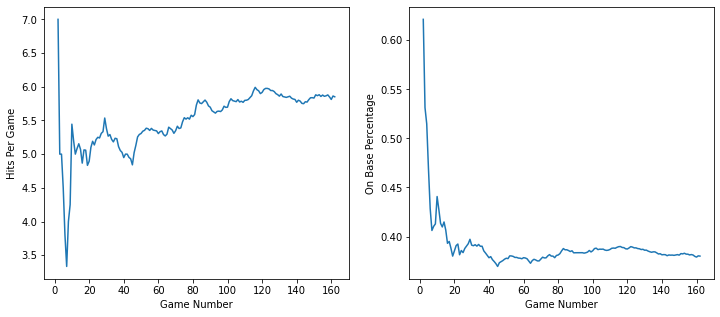

In [75]:
yankees_data = team_data[team_data['Team'] == 'New York Yankees']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(yankees_data['GameNum'], yankees_data['Runs_Mean'])
axes[0].set_xlabel('Game Number')
axes[0].set_ylabel('Hits Per Game')
axes[1].plot(yankees_data['GameNum'], yankees_data['OBP_Mean'])
axes[1].set_xlabel('Game Number')
axes[1].set_ylabel('On Base Percentage')

In [76]:
team_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858 entries, 0 to 633
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               4858 non-null   int64   
 1   Team                 4858 non-null   category
 2   GameNum              4858 non-null   int64   
 3   Opponent             4858 non-null   category
 4   GameNumOpponent      4858 non-null   int64   
 5   HomeAway             4858 non-null   category
 6   Runs                 4858 non-null   int64   
 7   Hits                 4858 non-null   int64   
 8   Errors               4858 non-null   int64   
 9   AB                   4858 non-null   int64   
 10  RBI                  4858 non-null   int64   
 11  BB                   4858 non-null   int64   
 12  SO                   4858 non-null   int64   
 13  PA                   4858 non-null   int64   
 14  OBP                  4858 non-null   float64 
 15  SLG                  4

For each game we'll join the cumulative data from the opponent so that we can use the other teams defensive ability in our predictions.

In [77]:
defensive_stats = ['GameID', 'Team', 'Runs_Mean_Opp', 'Hits_Mean_Opp', 'Errors_Mean_Opp', 'RBI_Mean_Opp', 'BB_Mean_Opp', 'SO_Mean_Opp', 
                   'SLG_Mean_Opp', 'OBP_Mean_Opp']
team_data =  team_data = team_data.merge(team_data[defensive_stats].copy(), how='left', left_on=['GameID', 'Opponent'], 
                                         right_on=['GameID', 'Team'], suffixes=('', '_Def'))
team_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858 entries, 0 to 4857
Data columns (total 70 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               4858 non-null   int64   
 1   Team                 4858 non-null   category
 2   GameNum              4858 non-null   int64   
 3   Opponent             4858 non-null   category
 4   GameNumOpponent      4858 non-null   int64   
 5   HomeAway             4858 non-null   category
 6   Runs                 4858 non-null   int64   
 7   Hits                 4858 non-null   int64   
 8   Errors               4858 non-null   int64   
 9   AB                   4858 non-null   int64   
 10  RBI                  4858 non-null   int64   
 11  BB                   4858 non-null   int64   
 12  SO                   4858 non-null   int64   
 13  PA                   4858 non-null   int64   
 14  OBP                  4858 non-null   float64 
 15  SLG                  

Finally, we'll want to add some odds to the data set that we can try out different betting strategies.

In [78]:
odds19 = pd.read_csv(os.path.join(parentDirectory, 'data', 'mlbodds2019.csv'))
odds_lookup2019 = clean_data.generate_odds_lookup(game_level, odds19)

odds_features = ['GameID', 'Close', 'Run Line', 'Run_Odds', 'Close OU', 'Close_OU_Odds',
                'Close_away', 'Run Line_away', 'Run_Odds_away', 'Close OU_away', 'Close_OU_Odds_away']
model_data19 = team_data.merge(odds_lookup2019[odds_features], how='left', left_on='GameID', right_on='GameID')
model_data19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858 entries, 0 to 4857
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               4858 non-null   object  
 1   Team                 4858 non-null   category
 2   GameNum              4858 non-null   int64   
 3   Opponent             4858 non-null   category
 4   GameNumOpponent      4858 non-null   int64   
 5   HomeAway             4858 non-null   category
 6   Runs                 4858 non-null   int64   
 7   Hits                 4858 non-null   int64   
 8   Errors               4858 non-null   int64   
 9   AB                   4858 non-null   int64   
 10  RBI                  4858 non-null   int64   
 11  BB                   4858 non-null   int64   
 12  SO                   4858 non-null   int64   
 13  PA                   4858 non-null   int64   
 14  OBP                  4858 non-null   float64 
 15  SLG                  

We have two more years worth of data but we've written a function to automate this data cleaning workflow for us. Let's apply that to the data from 2017 and 2018. We'll actually be using the 2019 data as our test data set and 2017/2018 for trainig.

In [79]:
# Import 2018 data
parsed18 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'rb'))
game_level18 = parsed18['Game']
team_level18 = parsed18['Team']

# Import 2017 data
parsed17 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'rb'))
game_level17 = parsed17['Game']
team_level17 = parsed17['Team']

# Clean data
model_data18 = clean_data.clean_team_season_data(team_level18, game_level18)
model_data17 = clean_data.clean_team_season_data(team_level17, game_level17)

# Add Odds
odds18 = pd.read_csv(os.path.join(parentDirectory, 'data', 'mlbodds2018.csv'))
odds_lookup18 = clean_data.generate_odds_lookup(game_level18, odds18)
odds17 = pd.read_csv(os.path.join(parentDirectory, 'data', 'mlbodds2017.csv'))
odds_lookup17 = clean_data.generate_odds_lookup(game_level17, odds17)
model_data18 = model_data18.merge(odds_lookup18[odds_features], how='left', left_on='GameID', right_on='GameID')
model_data17 = model_data17.merge(odds_lookup17[odds_features], how='left', left_on='GameID', right_on='GameID')

In [80]:
# Join 2017 and 2018 data and label train and test sets
train = pd.concat([model_data18, model_data17])
test = model_data19

## Data Exploration and Feature Selection

Now that we have all of the data we will use for our model let's explore it a little bit. There are many columns in the DataFrame above and we won't use all of them, so let's isolate the columns we want to explore more, separating them into numerical and categorical variables.

In [81]:
numerical_vars = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'SLG_Mean', 'OBP_Mean']
numerical_vars = numerical_vars + [name+'_Opp_Def' for name in numerical_vars]+['Runs']
categorical_vars = ['HomeAway']

Since it takes a few games for the averages to stabilize we'll remove the first 10 games from each season. Notice that we no longer have any null-values anymore.

In [82]:
train = train[train['GameNum'] > 30]
test = test[test['GameNum'] > 30]

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 900 to 4861
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               7924 non-null   object  
 1   Team                 7924 non-null   category
 2   GameNum              7924 non-null   int64   
 3   Opponent             7924 non-null   category
 4   GameNumOpponent      7924 non-null   int64   
 5   HomeAway             7924 non-null   category
 6   Runs                 7924 non-null   int64   
 7   Hits                 7924 non-null   int64   
 8   Errors               7924 non-null   int64   
 9   AB                   7924 non-null   int64   
 10  RBI                  7924 non-null   int64   
 11  BB                   7924 non-null   int64   
 12  SO                   7924 non-null   int64   
 13  PA                   7924 non-null   int64   
 14  OBP                  7924 non-null   float64 
 15  SLG                

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3958 entries, 900 to 4857
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GameID               3958 non-null   object  
 1   Team                 3958 non-null   category
 2   GameNum              3958 non-null   int64   
 3   Opponent             3958 non-null   category
 4   GameNumOpponent      3958 non-null   int64   
 5   HomeAway             3958 non-null   category
 6   Runs                 3958 non-null   int64   
 7   Hits                 3958 non-null   int64   
 8   Errors               3958 non-null   int64   
 9   AB                   3958 non-null   int64   
 10  RBI                  3958 non-null   int64   
 11  BB                   3958 non-null   int64   
 12  SO                   3958 non-null   int64   
 13  PA                   3958 non-null   int64   
 14  OBP                  3958 non-null   float64 
 15  SLG                

Let's look at the correlation matrix of the numerical columns.

In [85]:
train[numerical_vars].corr()['Runs']

Runs_Mean              0.085600
Hits_Mean              0.031612
Errors_Mean           -0.011889
RBI_Mean               0.083712
BB_Mean                0.063683
SO_Mean               -0.019591
SLG_Mean               0.077439
OBP_Mean               0.066490
Runs_Mean_Opp_Def      0.114487
Hits_Mean_Opp_Def      0.119104
Errors_Mean_Opp_Def   -0.062622
RBI_Mean_Opp_Def       0.113927
BB_Mean_Opp_Def        0.048021
SO_Mean_Opp_Def       -0.115999
SLG_Mean_Opp_Def       0.110140
OBP_Mean_Opp_Def       0.115700
Runs                   1.000000
Name: Runs, dtype: float64

Let's convert the home/away variable into dummy variables.

In [86]:
train_dummies = pd.get_dummies(train[categorical_vars], drop_first=True)
train = pd.concat([train, train_dummies], axis=1)

test_dummies = pd.get_dummies(test[categorical_vars], drop_first=True)
test = pd.concat([test, test_dummies], axis=1)

### Betting Odds

Let's add the amount that would've been won to the test set.

In [87]:
def american_odds_to_winnings(odds, bet_size):
    if odds > 0:
        return odds/100 * bet_size
    else:
        return  -100/odds*bet_size
    
test['ML_towin_home'] = test['Close'].apply(lambda x: american_odds_to_winnings(x, 10))
test['ATS_towin_home'] = test['Run_Odds'].apply(lambda x: american_odds_to_winnings(x, 10))
test['OU_towin'] = test['Close_OU_Odds'].apply(lambda x: american_odds_to_winnings(x, 10))
test['ML_towin_away'] = test['Close_away'].apply(lambda x: american_odds_to_winnings(x, 10))
test['ATS_towin_away'] = test['Run_Odds_away'].apply(lambda x: american_odds_to_winnings(x, 10))

We'll now define a funtion which which evaluates the ROI from a given model.

In [101]:
def evaluate_with_betting(test_data):
    test_home = test_data[test_data['HomeAway'] == 'Home']
    test_away = test_data[test_data['HomeAway'] == 'Away']
    test_combined = test_home.merge(test_away[['GameID', 'Predictions', 'Runs']], how='inner', on='GameID', suffixes=('_home', '_away'))
    test_combined['predicted_point_diff'] = test_combined['Predictions_away'] - test_combined['Predictions_home']
    test_combined['predicted_total'] = test_combined['Predictions_away'] + test_combined['Predictions_home']
    test_combined['point_diff'] = test_combined['Runs_away'] - test_combined['Runs_home']
    test_combined['total'] = test_combined['Runs_away'] + test_combined['Runs_home']
    test_combined['spread_diff'] = test_combined['predicted_point_diff'] - test_combined['Run Line']
    test_combined['spread_diff_rounded'] = test_combined['spread_diff'].round()
    test_combined['total_diff'] = test_combined['predicted_total'] - test_combined['Close OU']
    def eval_ml(row):
        if row['predicted_point_diff']*row['point_diff'] > 0:
            if row['predicted_point_diff'] < 0:
                return row['ML_towin_home']
            else:
                return row['ML_towin_away']
        else:
            return -10
    test_combined['ML_winnings'] = test_combined.apply(eval_ml, axis=1)
    test_combined['ML_correct'] = test_combined['ML_winnings'].apply(lambda x: 1 if x>0 else 0)
    def eval_ats(row):
        to_bet = row['spread_diff'] * (row['point_diff'] - row['Run Line'])
        if to_bet > 0:
            if row['spread_diff'] < 0:
                return row['ATS_towin_home']
            else:
                return row['ATS_towin_away']
        elif to_bet < 0:
            return -10
        else:
            return 0
    test_combined['ATS_winnings'] = test_combined.apply(eval_ats, axis=1)
    test_combined['ATS_correct'] = test_combined['ATS_winnings'].apply(lambda x: 1 if x>0 else 0)
    def eval_OU(row):
        to_bet = row['total_diff'] * (row['total'] - row['Close OU'])
        if to_bet > 0:
            return row['OU_towin']
        elif to_bet < 0:
            return -10
        else:
            return 0
    test_combined['OU_winnings'] = test_combined.apply(eval_OU, axis=1)
    test_combined['OU_correct'] = test_combined['OU_winnings'].apply(lambda x: 1 if x>0 else 0)
    test_combined.sort_values(by='GameNum', inplace=True)
    betting_vars = ['ML_balance', 'ATS_balance', 'OU_balance']
    test_combined[betting_vars] = (test_combined.expanding().sum()[['ML_winnings', 'ATS_winnings', 'OU_winnings']].reset_index(level=0, drop=True))
    return test_combined

## Model Selection
### Linear Regression
We'll begin by fitting a linear regression model using Recursive Feature Elimination.

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

predictors = numerical_vars[:-1] + ['HomeAway_Home']

# Create cross validator
kfolds = KFold(n_splits=10, random_state=1988, shuffle=True)

# Define estimator
lm = LinearRegression()

# Create and fit selector
selector = RFECV(lm, cv=kfolds, scoring='neg_mean_squared_error')
selector.fit(train[predictors], train['Runs'])
lm_best_predictors = train[predictors].columns[selector.support_]
print(lm_best_predictors)

# Extract model
lm_best = selector.estimator_

Index(['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean',
       'SO_Mean', 'SLG_Mean', 'OBP_Mean', 'Runs_Mean_Opp_Def',
       'Hits_Mean_Opp_Def', 'Errors_Mean_Opp_Def', 'BB_Mean_Opp_Def',
       'SO_Mean_Opp_Def', 'SLG_Mean_Opp_Def', 'OBP_Mean_Opp_Def',
       'HomeAway_Home'],
      dtype='object')


We'll now evaluate this on the test set and save the mean squared error.

In [96]:
from sklearn.metrics import mean_squared_error
rmses = {}
train_predictions = lm_best.predict(train[lm_best_predictors])
train_rmse = np.sqrt(mean_squared_error(train_predictions, train['Runs']))
predictions = lm_best.predict(test[lm_best_predictors])
rmses['Linear Regression'] = np.sqrt(mean_squared_error(predictions, test['Runs']))
print('The root MSE for Linear Regression on training set is %f and on test set is %f.' % (train_rmse, rmses['Linear Regression']))

The root MSE for Linear Regression on training set is 3.126872 and on test set is 3.337356.


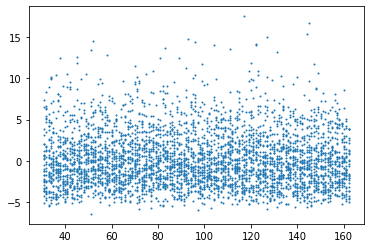

In [97]:
test_residuals = test['Runs'] - predictions
plt.scatter(test['GameNum'], test_residuals, s=1)

In [102]:
test['Predictions'] = predictions
test_eval_lm = evaluate_with_betting(test)

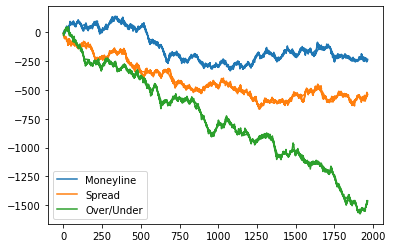

In [103]:
plt.plot(test_eval_lm['ML_balance'], label='Moneyline')
plt.plot(test_eval_lm['ATS_balance'], label='Spread')
plt.plot(test_eval_lm['OU_balance'], label='Over/Under')
plt.legend()

## LASSO and Ridge Regression

When we plotted our correlation matrix we saw that there was quite a bit of collinearity. Let's apply LASSO and Ridge regression to see if we can improve on our estimates. We'll start with LASSO first.

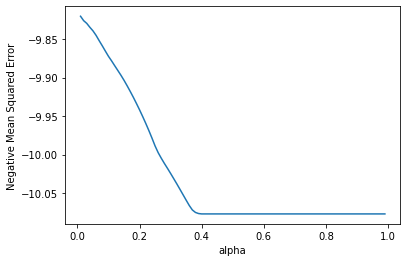

In [109]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# We'll try a variaty of different values for alpha (the coefficient on the L1 penalty)
alphas = list(np.arange(.01, 1, .01))

# Normalize data
train_normalized = (train[predictors] - train[predictors].mean())/train[predictors].std()
test_normalized = (test[predictors]-train[predictors].mean())/train[predictors].std()

alpha_losses_lasso = []
# Loop through alphas and test each one
for alpha in alphas:
    # Define LASSO estimator
    lasso = Lasso(alpha=alpha)
    
    # Cross Validate using samel KFold as above
    alpha_losses_lasso.append(cross_val_score(lasso, train_normalized, train['Runs'], scoring='neg_mean_squared_error', cv=kfolds).mean())
    
fig, ax = plt.subplots()
ax.plot(alphas, alpha_losses_lasso)
ax.set_xlabel('alpha')
ax.set_ylabel('Negative Mean Squared Error')
plt.show()

Based on the plot above it indicates the the best mean_squared error is actually achieved by Linear Regression so we'll stop here with Lasso and take a quick look at Ridge.

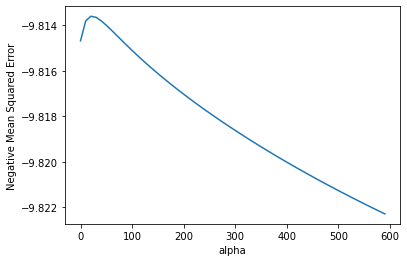

20


In [110]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# We'll try a variaty of different values for alpha (the coefficient on the L2 penalty)
alphas = list(np.arange(0, 600, 10))

alpha_losses_ridge = []
# Loop through alphas and test each one
for alpha in alphas:
    # Define Ridge Regression estimator
    ridge = Ridge(alpha=alpha)
    
    # Cross Validate using samel KFold as above
    alpha_losses_ridge.append(cross_val_score(ridge, train_normalized, train['Runs'], scoring='neg_mean_squared_error', cv=kfolds).mean())
    
fig, ax = plt.subplots()
ax.plot(alphas, alpha_losses_ridge)
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('alpha')
ax.set_ylabel('Negative Mean Squared Error')
plt.show()
print(alphas[alpha_losses_ridge.index(max(alpha_losses_ridge))])

We'll also try 190 since that the true maximum in the above plot. Let's compare these two values to the test set and see how they do compared to Linear Regression.

In [116]:
alpha = 20

# Define model
ridge = Ridge(alpha=alpha)

# Fit model
ridge.fit(train_normalized, train['Runs'])

# Make predictions
predictions = ridge.predict(test_normalized)

# Compute MSE
rmses['Ridge Regression'] = np.sqrt(mean_squared_error(predictions, test['Runs']))
print('The root MSE for Ridge Regression with alpha=%f is %f' % (alpha, rmses['Ridge Regression']))

The root MSE for Ridge Regression with alpha=20.000000 is 3.335875


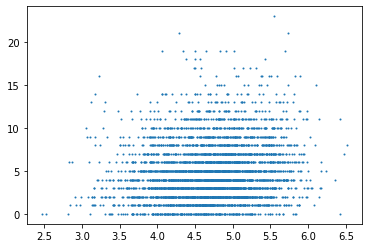

In [120]:
plt.scatter(predictions, test['Runs'], s=1)

In [121]:
test['Predictions'] = predictions
test_eval_ridge = evaluate_with_betting(test)

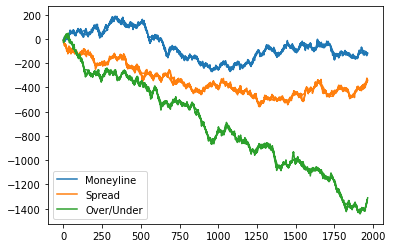

In [122]:
plt.plot(test_eval_ridge['ML_balance'], label='Moneyline')
plt.plot(test_eval_ridge['ATS_balance'], label='Spread')
plt.plot(test_eval_ridge['OU_balance'], label='Over/Under')
plt.legend()

These are almost exactly the same as Linear Regression. Let's try some more advance machine learning techniques.

## Random Forest

We'll apply a Random Forest Regressor and see if this can improve our estiamtes.

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
rf.fit(train_normalized, train['Runs'])
predictions = rf.predict(test_normalized)
np.sqrt(mean_squared_error(predictions, test['Runs']))

3.5234677574653537

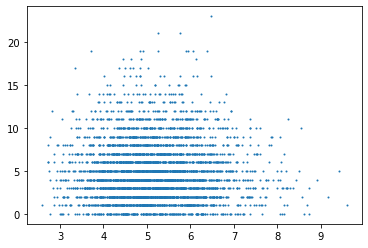

In [124]:
plt.scatter(predictions, test['Runs'], s=1)

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [40, 50, 60],
'min_samples_split' : [2, 3, 4],
'min_samples_leaf' : [1, 2, 3]
    
}

rf = RandomForestRegressor(n_estimators=50)
gscv = GridSearchCV(rf, params, cv=2, scoring='neg_mean_squared_error')
gscv.fit(train_normalized, train['Runs'])
print(gscv.best_params_)

{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [126]:
rf = RandomForestRegressor(n_estimators=500, max_features='log2', max_depth=50, min_samples_leaf=1, min_samples_split=2)
rf.fit(train_normalized, train['Runs'])
predictions = rf.predict(test_normalized)
np.sqrt(mean_squared_error(predictions, test['Runs']))

3.442965354390177

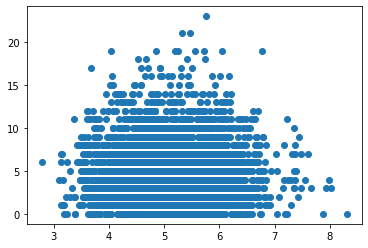

In [127]:
plt.scatter(predictions, test['Runs'])

In [128]:
test['Predictions'] = predictions
test_eval_rf = evaluate_with_betting(test)

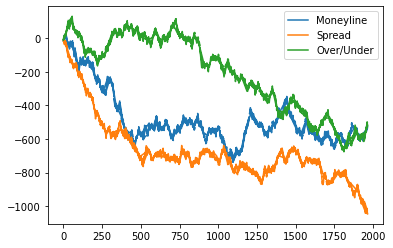

In [129]:
plt.plot(test_eval_rf['ML_balance'], label='Moneyline')
plt.plot(test_eval_rf['ATS_balance'], label='Spread')
plt.plot(test_eval_rf['OU_balance'], label='Over/Under')
plt.legend()